In [2]:
import pandas as pd
import time
from tqdm.notebook import tqdm

In [ ]:
def scrape_race_results(race_id_list, pre_race_results={}):
    race_results = pre_race_results.copy()
    for race_id in tqdm(race_id_list):
        if race_id in race_results.keys():
            continue
        time.sleep(1)
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            race_results[race_id] = pd.read_html(url)[0]
        except IndexError:
            continue
        except AttributeError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return race_results

#レースIDのリストを作る
race_id_list = []
for place in range(1, 11, 1):
    for kai in range(1, 6, 1):
        for day in range(1, 13, 1):
            for r in range(1, 13, 1):
                race_id = "2022" + str(place).zfill(2) + str(kai).zfill(2) +\
                str(day).zfill(2) + str(r).zfill(2)
                race_id_list.append(race_id)

#スクレイピングしてデータを保存
test3 = scrape_race_results(race_id_list)
for key in test3:
    test3[key].index = [key] * len(test3[key])
results = pd.concat([test3[key] for key in test3], sort=False) 
results.to_pickle('results.pickle')

In [ ]:
import requests
from bs4 import BeautifulSoup
import time
from tqdm.notebook import tqdm
import re
import datetime

def scrape_race_info(race_id_list):
    race_infos = {}
    for race_id in tqdm(race_id_list):
        time.sleep(1)
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")

            texts = (
                soup.find("div", attrs={"class": "data_intro"}).find_all("p")[0].text
                + soup.find("div", attrs={"class": "data_intro"}).find_all("p")[1].text
            )
            info = re.findall(r"\w+", texts)
            info_dict = {}
            for text in info:
                if text in ["芝", "ダート"]:
                    info_dict["race_type"] = text
                if "障" in text:
                    info_dict["race_type"] = "障害"
                if "m" in text:
                    info_dict["course_len"] = int(re.findall(r"\d+", text)[0])
                if text in ["良", "稍重", "重", "不良"]:
                    info_dict["ground_state"] = text
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    info_dict["weather"] = text
                if "年" in text:
                    info_dict["date"] = text
            race_infos[race_id] = info_dict
        except IndexError:
            continue
        except AttributeError: #存在しないrace_idでAttributeErrorになるページもあるので追加
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return race_infos

#前回保存したpickleファイルからデータ取得
results = pd.read_pickle('results.pickle')

#レースID一覧を取得してスクレイピング
race_id_list = results.index.unique()
race_infos = scrape_race_info(race_id_list)

#DataFrame型にする
race_infos = pd.DataFrame(race_infos).T

#resultsに結合
results_addinfo = results.merge(race_infos, left_index=True, right_index=True, how="inner")

In [ ]:
from urllib.request import urlopen

def scrape_return_tables(race_id_list):
    return_tables = {}
    for race_id in tqdm(race_id_list):
        time.sleep(1)
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            
            #普通にスクレイピングすると複勝やワイドなどが区切られないで繋がってしまう。
            #そのため、改行コードを文字列brに変換して後でsplitする
            f = urlopen(url)
            html = f.read()
            html = html.replace(b'<br />', b'br')
            dfs = pd.read_html(html)

            #dfsの1番目に単勝〜馬連、2番目にワイド〜三連単がある
            df = pd.concat([dfs[1], dfs[2]])

            df.index = [race_id] * len(df)
            return_tables[race_id] = df
        except IndexError:
            continue
        except AttributeError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return return_tables

results = pd.read_pickle('results.pickle')

#レースID一覧を取得してスクレイピング
race_id_list = results.index.unique()
race_return = scrape_return_tables(race_id_list)

race_return.to_pickle('race_return.pickle')

print(race_return)

In [82]:
return_tables = race_return

for key in return_tables.keys():
    return_tables[key].index = [key]*len(return_tables[key])

return_tables = pd.concat([return_tables[key] for key in return_tables.keys()])

return_tables.to_pickle('race_return.pickle')


def fukusho(return_tables):
    fukusho = return_tables[return_tables[0]=='複勝'][[1,2]]
    wins = fukusho[1].str.split('br', expand=True)[[0,1,2]]
    
    wins.columns = ['win_0', 'win_1', 'win_2']

    returns = fukusho[2].str.split('br', expand=True)[[0,1,2]]
    returns.columns = ['return_0', 'return_1', 'return_2']
    
    df = pd.concat([wins, returns], axis=1)
    for column in df.columns:
        df[column] = df[column].str.replace(',', '')
    return df.fillna(0).astype(int)

fukusho_data = fukusho(return_tables)

fukusho_data.to_pickle('fukusho.pickle')

print(fukusho_data)

              win_0  win_1  win_2  return_0  return_1  return_2
202201010101      1      3      0       100       210         0
202201010102      3      8      4       200       180       140
202201010103     12      1      4       110       410      2620
202201010104     11      4     16       600       150       220
202201010105      8      4     12       330       160       780
...             ...    ...    ...       ...       ...       ...
202210040808      8      3      6       110       110       180
202210040809     18      6      2       190       300      1460
202210040810      6     12     14       360       870       270
202210040811      1     11     13       280       860      1080
202210040812     15     10      3       180       160       450

[3276 rows x 6 columns]


In [5]:

#date列の処理を追加
def preprocessing(results):
    df = results.copy()

    # 着順に数字以外の文字列が含まれているものを取り除く
    df = df[~(df["着順"].astype(str).str.contains("\D"))]
    df["着順"] = df["着順"].astype(int)

    # 性齢を性と年齢に分ける
    df["性"] = df["性齢"].map(lambda x: str(x)[0])
    df["年齢"] = df["性齢"].map(lambda x: str(x)[1:]).astype(int)

    # 馬体重を体重と体重変化に分ける
    df["体重"] = df["馬体重"].str.split("(", expand=True)[0].astype(int)
    df["体重変化"] = df["馬体重"].str.split("(", expand=True)[1].str[:-1].astype(int)

    # データをint, floatに変換
    df["単勝"] = df["単勝"].astype(float)

    # 不要な列を削除
    df.drop(["タイム", "着差", "調教師", "性齢", "馬体重"], axis=1, inplace=True)
    
    df["date"] = pd.to_datetime(df["date"], format="%Y年%m月%d日")

    return df



#前処理
#results_p = preprocessing(results_addinfo)


In [28]:

#時系列に沿ってデータを分割
def split_data(df, test_size):
    sorted_id_list = df.sort_values("date").index.unique()
    train_id_list = sorted_id_list[: round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)) :]
    train = df.loc[train_id_list]
    test = df.loc[test_id_list]
    return train, test,test_id_list




In [92]:
#results_addinfo.to_pickle('results.pickle')

#上で保存したpickleファイルの読み込み
results = pd.read_pickle('results.pickle')

#前処理
results_p = preprocessing(results)

results_p.drop(["馬名"], axis=1, inplace=True)
results_d = pd.get_dummies(results_p)

#着順を0or1にする
results_d["rank"] = results_d["着順"].map(lambda x: x if x < 4 else 4)
train, test,test_id_list = split_data(results_d, test_size=0.3)
X_train = train.drop(["着順", "date", "rank"], axis=1)
y_train = train["rank"]
X_test = test.drop(["着順", "date", "rank"], axis=1)
y_test = test["rank"]
y_train = y_train.map(lambda x: 1 if x < 4 else 0)
y_test = y_test.map(lambda x: 1 if x < 4 else 0)

#LightGBMによる予測モデル作成
import lightgbm as lgb

params = {
    "num_leaves": 4,
    "n_estimators": 80,
    #'min_data_in_leaf': 15,
    "class_weight": "balanced",
    "random_state": 100,
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]

#ベンチマーク計算用のデータ
X_test_with_pred = test.copy()
X_test_with_pred = X_test_with_pred.drop(["date","枠番","斤量"], axis=1)
X_test_with_pred['予想確率'] = y_pred
X_test_with_pred['race_id'] = X_test_with_pred.index
fukusho = pd.read_pickle('fukusho.pickle')
fukusho['race_id'] = fukusho.index

# winとreturnを整形して一つのDataFrameにまとめる
reshaped_fukusho_list = []
for idx, row in fukusho.iterrows():
    for i in range(3):  # 0, 1, 2
        win = row[f'win_{i}']
        ret = row[f'return_{i}']
        reshaped_fukusho_list.append({'race_id': idx, '馬番': win, '複勝': ret / 100})

reshaped_fukusho_df = pd.DataFrame(reshaped_fukusho_list)

# x_testと整形したDataFrameを結合
X_test_with_pred = pd.merge(X_test_with_pred, reshaped_fukusho_df, on=['race_id', '馬番'], how='left').fillna(0)

print(X_test_with_pred['複勝'])

X_test_with_pred.to_pickle('x_test.pickle')

#ROC曲線の表示
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

#変数の重要度の表示
importances = pd.DataFrame(
    {"features": X_train.columns, "importance": lgb_clf.feature_importances_}
)
importances.sort_values("importance", ascending=False)[:20]

[LightGBM] [Info] Number of positive: 6880, number of negative: 24278
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 872
[LightGBM] [Info] Number of data points in the train set: 31158, number of used features: 195
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
0        1.7
1        2.0
2        3.4
3        0.0
4        0.0
        ... 
13248    0.0
13249    0.0
13250    0.0
13251    0.0
13252    0.0
Name: 複勝, Length: 13253, dtype: float64
0.8224835816520651
0.8127727033745515


,features,importance
3,単勝,129
4,人気,19
1,馬番,13
6,体重,12
0,枠番,9
5,年齢,8
7,体重変化,6
29,騎手_丹内祐次,5
26,騎手_中村将之,5
169,騎手_藤田菜七,5


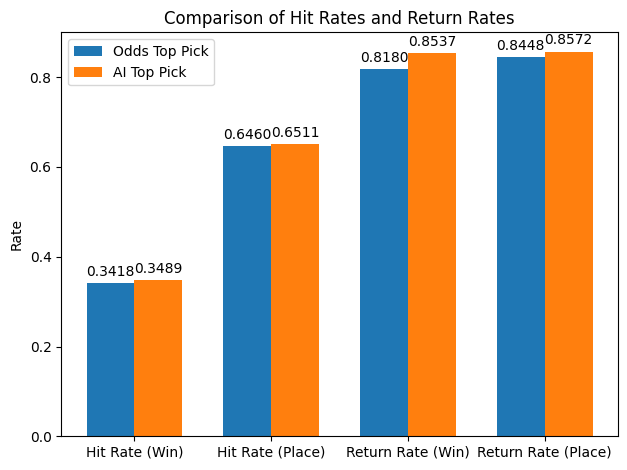

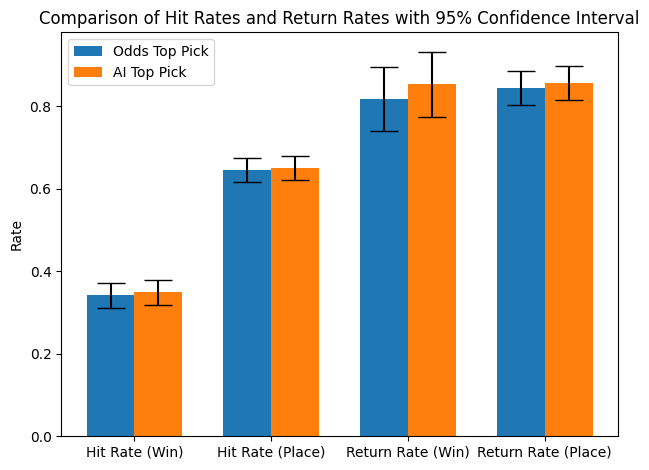

(-1131177062479636.0, 0.0)

In [98]:
# 必要なライブラリをインポート
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

# 的中率と回収率を計算する関数
def calculate_rates(df):
    tansho_odds_column = '単勝'
    fukusho_odds_column = '複勝'
    actual_rank_column = '着順'
    
    total_bets = len(df)
    hits = len(df[df[actual_rank_column] == 1])
    places = len(df[df[actual_rank_column] <= 3])
    hit_rate = hits / total_bets
    place_rate = places / total_bets
    win_return_rate = df[df[actual_rank_column] == 1][tansho_odds_column].sum() / total_bets
    place_return_rate = df[df[actual_rank_column] <= 3][fukusho_odds_column].sum() / total_bets
    
    return pd.Series([hit_rate, place_rate, win_return_rate, place_return_rate], 
                     index=['hit_rate', 'place_rate', 'win_return_rate', 'place_return_rate'])


#上で保存した評価用データセットにAI予測確率を結合したファイルの読み込み
results = pd.read_pickle('x_test.pickle')

# 予測確率をデータフレームに追加
results_df = results

# オッズとAIによる最良の馬を特定
odds_best_horses = results_df.sort_values(['race_id', '単勝']).drop_duplicates(subset='race_id')
ai_best_horses = results_df.sort_values(['race_id', '予想確率'], ascending=[True, False]).drop_duplicates(subset='race_id')

# RaceIDごとに的中率と回収率を計算
odds_metrics = odds_best_horses.groupby('race_id').apply(calculate_rates)
ai_metrics = ai_best_horses.groupby('race_id').apply(calculate_rates)

# 平均的中率と回収率を計算
avg_odds_metrics = odds_metrics.mean()
avg_ai_metrics = ai_metrics.mean()

# グラフを作成する関数
def plot_comparison(labels, odds_rates, ai_rates):
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, odds_rates, width, label='Odds Top Pick')
    rects2 = ax.bar(x + width/2, ai_rates, width, label='AI Top Pick')

    # 数値をバーの上に追加
    for rect in rects1:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    ax.set_ylabel('Rate')
    ax.set_title('Comparison of Hit Rates and Return Rates')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()

    plt.show()

# プロット用データの準備
labels = ['Hit Rate (Win)', 'Hit Rate (Place)', 'Return Rate (Win)', 'Return Rate (Place)']
odds_rates = avg_odds_metrics.values
ai_rates = avg_ai_metrics.values

# グラフを作成
plot_comparison(labels, odds_rates, ai_rates)

# 信頼区間を計算する関数
from scipy import stats
import numpy as np

# 信頼区間を計算する関数
def calculate_confidence_interval(data, confidence=0.95):
    data = np.array(data)
    mean = np.mean(data)
    std_err = stats.sem(data)
    dof = len(data) - 1
    ci = std_err * stats.t.ppf((1 + confidence) / 2, dof)
    return mean, ci

# 信頼区間を計算
odds_hit_rates_ci = calculate_confidence_interval(odds_metrics['hit_rate'])
odds_place_rates_ci = calculate_confidence_interval(odds_metrics['place_rate'])
odds_win_return_rates_ci = calculate_confidence_interval(odds_metrics['win_return_rate'])
odds_place_return_rates_ci = calculate_confidence_interval(odds_metrics['place_return_rate'])

ai_hit_rates_ci = calculate_confidence_interval(ai_metrics['hit_rate'])
ai_place_rates_ci = calculate_confidence_interval(ai_metrics['place_rate'])
ai_win_return_rates_ci = calculate_confidence_interval(ai_metrics['win_return_rate'])
ai_place_return_rates_ci = calculate_confidence_interval(ai_metrics['place_return_rate'])

# プロット用データの準備
labels = ['Hit Rate (Win)', 'Hit Rate (Place)', 'Return Rate (Win)', 'Return Rate (Place)']
odds_rates = [odds_hit_rates_ci[0], odds_place_rates_ci[0], odds_win_return_rates_ci[0], odds_place_return_rates_ci[0]]
ai_rates = [ai_hit_rates_ci[0], ai_place_rates_ci[0], ai_win_return_rates_ci[0], ai_place_return_rates_ci[0]]
odds_ci = [odds_hit_rates_ci[1], odds_place_rates_ci[1], odds_win_return_rates_ci[1], odds_place_return_rates_ci[1]]
ai_ci = [ai_hit_rates_ci[1], ai_place_rates_ci[1], ai_win_return_rates_ci[1], ai_place_return_rates_ci[1]]

# グラフを作成
x = np.arange(len(labels))
width = 0.35
fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, odds_rates, width, label='Odds Top Pick', yerr=odds_ci, capsize=10)
rects2 = ax.bar(x + width/2, ai_rates, width, label='AI Top Pick', yerr=ai_ci, capsize=10)

ax.set_ylabel('Rate')
ax.set_title('Comparison of Hit Rates and Return Rates with 95% Confidence Interval')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()